In [71]:
import numpy as np
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Tuple, Optional, overload
from src import utils, parametrizations
import torch.nn.utils.parametrize as parametrize
from torch.nn.utils.parametrizations import orthogonal, spectral_norm
import matplotlib.pyplot as plt

In [102]:
class GW_Net(nn.Module):
    def __init__(self, hidden_size = 32, p = 5, input_size = 1, output_size = 10, g = 1.5, s_max = 1, dt = 15, device = None):
        super().__init__()        
        
        self.hidden_size = hidden_size
        self.p = p
        self.ns = [self.hidden_size for _ in range(self.p)]
        self.N = sum(self.ns)
        self.output_size = output_size        
        self.input_size = input_size
        
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
            
        self.alpha = alpha
        self.device = device

        self.input2h = nn.Linear(self.input_size, self.N, bias = True, device = self.device)  
        self.h2output = nn.Linear(self.N, self.output_size, device = self.device)
        
        self.g = g 
        self.s_max = s_max
        W, F, A, B = self.build_GW_Net()
        
        self.W = W.to(self.device)
        self.F = F.to(self.device)
        self.A = nn.Linear(self.N,self.N,bias = False, device = self.device)
        self.A.weight = nn.Parameter(A.to(self.device))
        
        self.B = B.to(self.device)        
        self.h2h = nn.Linear(self.N,self.N, bias = False, device = self.device)
        self.h2h.weight = nn.Parameter(self.W.to(self.device))  
        self.h2h.weight.requires_grad = False
        
    def build_GW_Net(self):
       
        # RNN of RNNs adjecency matrix
        A_tril = torch.zeros((self.p, self.p))
        A_tril[-1, :] = 1
        
        
        # mask to define interareal connectivity
        B_mask = utils.create_mask_given_A(A_tril, self.ns)
        B = B_mask
        B = 0.5*(B + B.T)
        B[B == 1] = 0  
        

        # fixed interareal weights (default zero)
        X = torch.zeros(self.N, self.N)
        F = B*X - (B*X).T

        # adaptable weights
        A = torch.eye(self.N)
        A = A*B

        # intra-areal weights, singular values less than or equal to unity
        blocks = utils.create_mask_given_A(np.eye(self.p), self.ns)
        W = torch.normal(mean = 0, std = self.g/np.sqrt(self.hidden_size), size = (self.N,self.N))
        W *= blocks

        # sparsify h2h weights
        random_W_mask = np.random.choice([0,1],p = [0.8,0.2],size = (self.N,self.N))
        random_W_mask = torch.from_numpy(random_W_mask)
        W *= random_W_mask

        # project h2h to unit norm
        u,s,vt = torch.linalg.svd(W)
        s = torch.clamp(s,0,self.s_max)
        W = u @ np.diag(s) @ vt

        return W, F, A, B
    
    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.ones(batch_size, self.N, device = self.device)
    
    def recurrence(self, input, x):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        # firing rate
        h = torch.relu(x) 
        
        # update network one time step
        f =  -x + self.h2h(h) + self.input2h(input)# + self.A(h)
        x_new = x + self.alpha*f
        
        return x_new
        

    def forward(self, input, x=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if x is None:
            x = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            x = self.recurrence(input[i], x)
            output.append(x)

        # Stack together output from all time steps
        output = torch.stack(output, dim = 0)  # (seq_len, batch, hidden_size)
        
        # apply linear readout layer
        readout = self.h2output(output)
        
        return readout,output, x


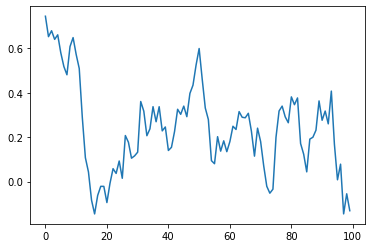

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_in = 10
N_out = 3
gwnet = GW_Net(input_size = N_in, output_size = N_out,device = device,s_max = 1)

T = 100
trials = 20

inp = torch.randn(T, trials, N_in, device = device)
readout, output, x = gwnet(inp)

output.shape
with torch.no_grad():
    plt.plot(output[:,0,0].detach().cpu())

In [105]:
eeg_train = np.load('/om2/user/leokoz8/code/rnns-of-rnns/data/EEG_train.npy')

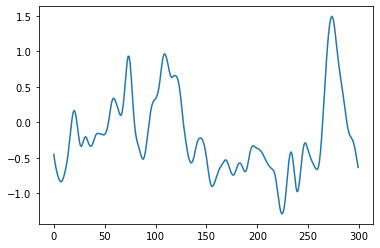

In [117]:
# Create a Hanning window of size 15
window_size = 15
hanning_window = np.hanning(window_size)

# Normalize the Hanning window to make its sum equal to 1
hanning_window /= np.sum(hanning_window)

# Convolve the time-series with the Hanning window
smoothed_time_series = np.convolve(eeg_train[:,0], hanning_window, mode='same')




plt.plot(eeg_train[0:300,0])